In [1]:
pip install tensorflow-gpu==2.8.3

     -------------------------------------- 438.4/438.4 MB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 42.6/42.6 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 9.8 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 11.2 MB/s eta 0:00:00
     ------------------------------------- 462.3/462.3 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.8.0 which is incompatible.


In [2]:
from tensorflow.keras import layers, models 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potatodisease",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

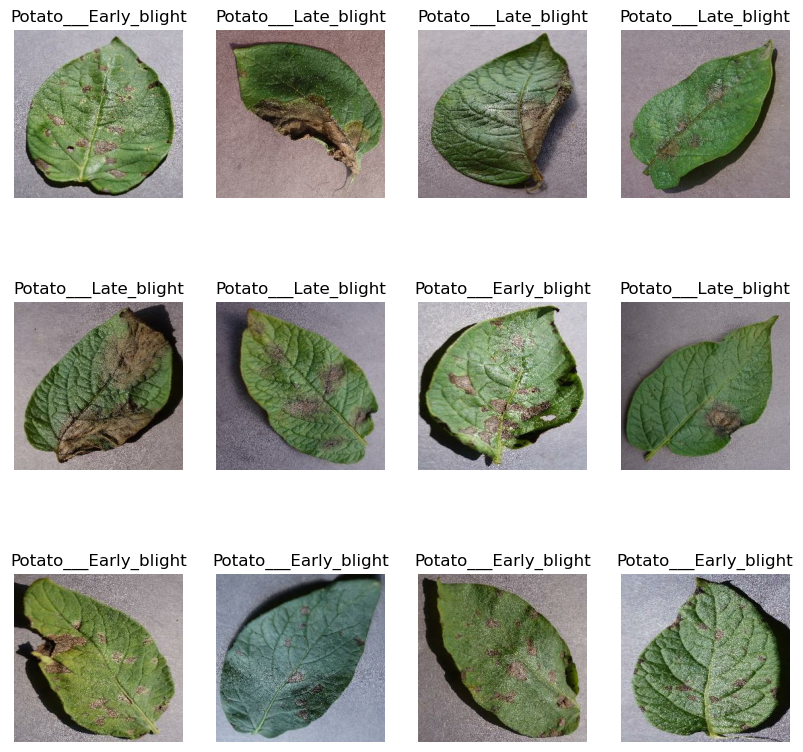

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_datset_partitions_df(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        df = df.shuffle(shuffle_size, seed=12)
    ds_size = len(df)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = df.take(train_size)
    val_ds = df.skip(train_size).take(val_size)
    test_ds = df.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_datset_partitions_df(dataset)

In [9]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape = input_shape), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


C:\Users\DELL\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/54 [==============================] - 69s 1s/step - loss: 0.9155 - accuracy: 0.4774 - val_loss: 0.8986 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 64s 1s/step - loss: 0.7541 - accuracy: 0.6140 - val_loss: 0.6158 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 64s 1s/step - loss: 0.4288 - accuracy: 0.8125 - val_loss: 0.4297 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 63s 1s/step - loss: 0.2933 - accuracy: 0.8860 - val_loss: 0.4128 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 63s 1s/step - loss: 0.2741 - accuracy: 0.8924 - val_loss: 0.5414 - val_accuracy: 0.7812
Epoch 6/50
54/54 [==============================] - 64s 1s/step - loss: 0.2324 - accuracy: 0.8987 - val_loss: 0.2638 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 63s 1s/step - loss: 0.1760 - accuracy: 0.9340 - val_loss: 0.2719 - val_accuracy: 0.8958
Epoch 8/50
54/54 [=============

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 203ms/step - loss: 0.0967 - accuracy: 0.9492


In [19]:
scores

[0.09669388085603714, 0.94921875]

In [20]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
len(history.history['accuracy'])

50

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

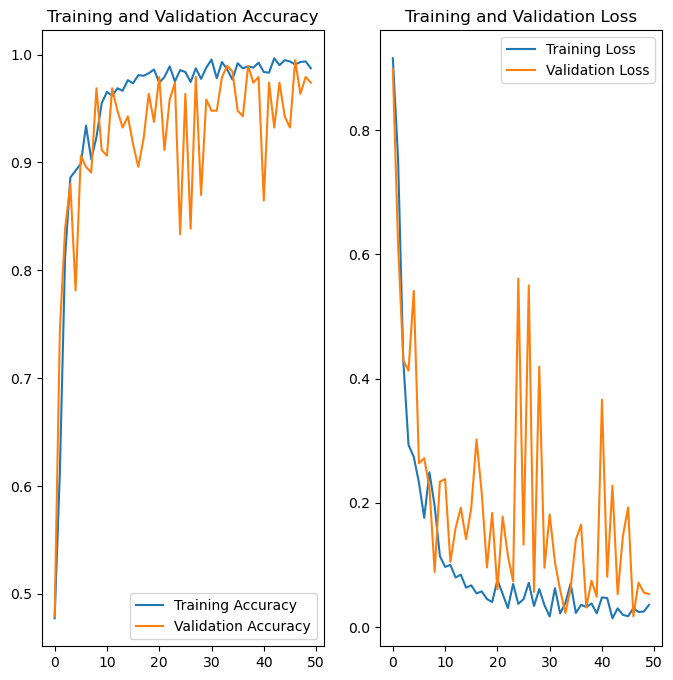

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')


First Image to Predict
First Image's Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight


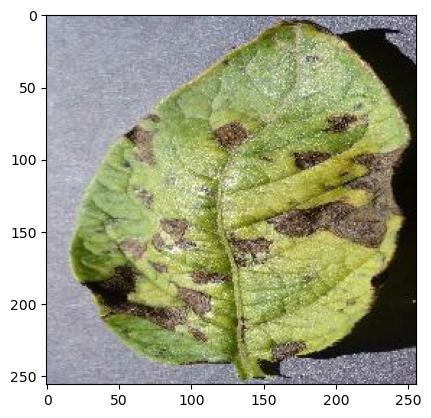

In [26]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print('First Image to Predict')
    plt.imshow(first_image)
    print(f'First Image\'s Actual Label: {class_names[first_label]}')
    
    batch_prediction = model.predict(image_batch)
    print(f'Predicted Label: {class_names[np.argmax(batch_prediction[0])]}')

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

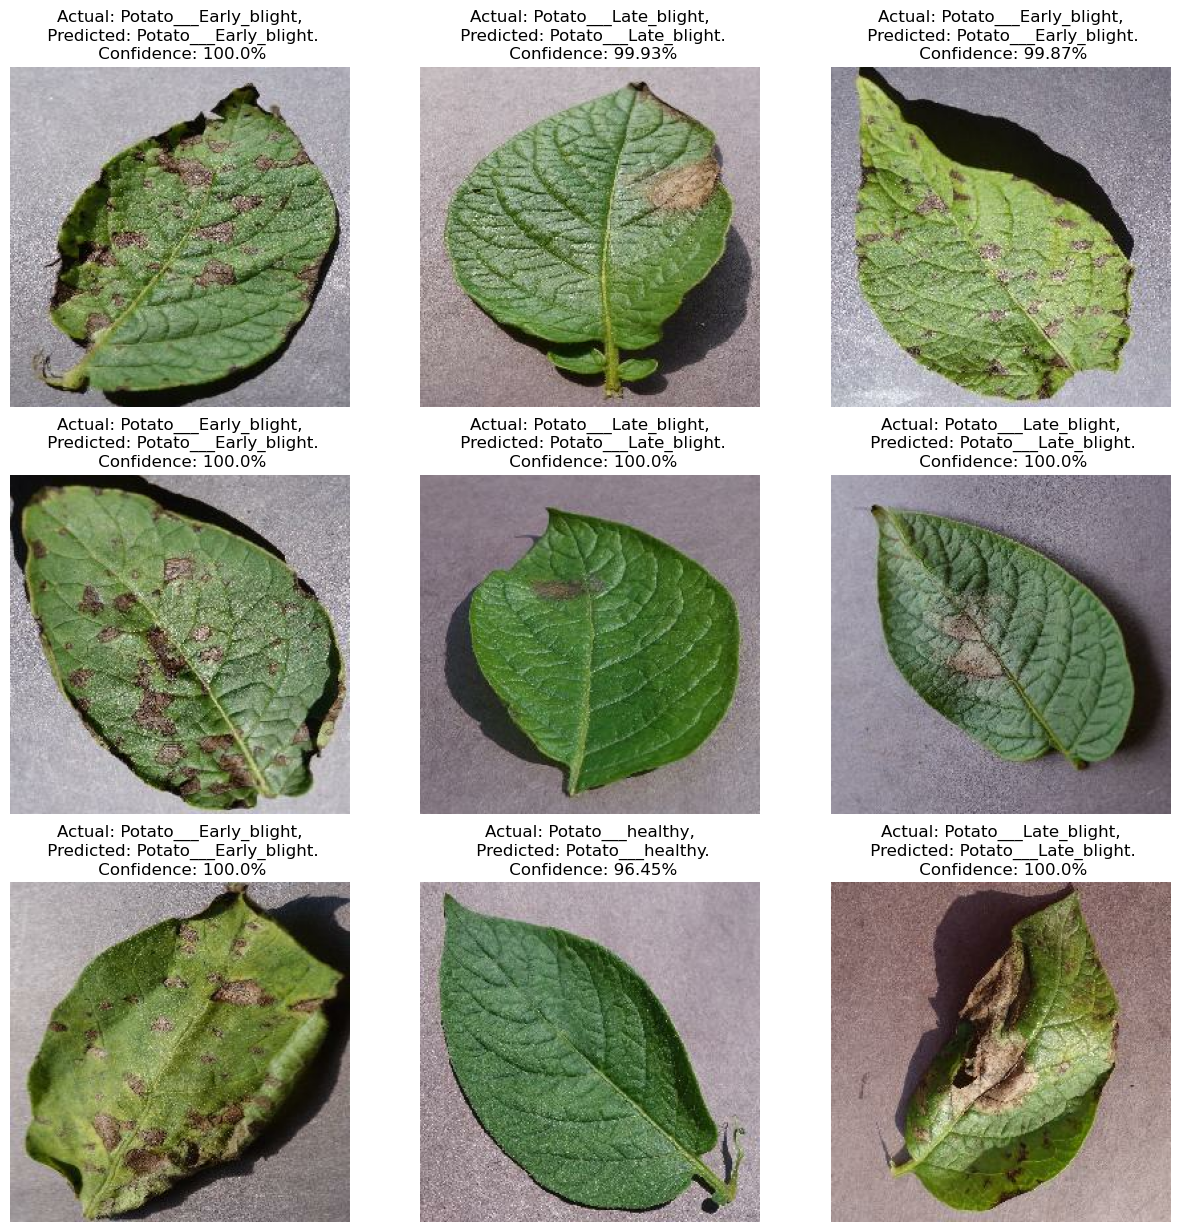

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Potato___Early_blight
Potato___Early_blight


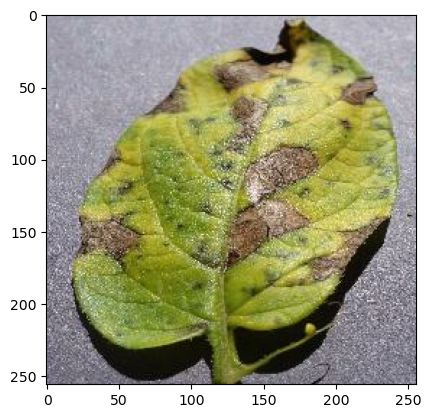

In [29]:
for image_batch,label in dataset.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  plt.imshow(first_image)
  print(class_names[label[0].numpy()])
  batch_prediction=model.predict(image_batch)
  print(class_names[np.argmax(batch_prediction[0])])

In [35]:
model.save("model.h5")